# NeoKart Analytics BDM Project Analysis

 1. Import Required Libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA

sns.set(style='whitegrid')

2. Load and Explore Data

In [ ]:
data = pd.read_csv('/content/online_retail_II.csv', encoding='ISO-8859-1')
print("Dataset shape:", data.shape)
print(data.head())

Dataset shape: (200479, 8)
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS      12.0   
1  489434    79323P                   PINK CHERRY LIGHTS      12.0   
2  489434    79323W                  WHITE CHERRY LIGHTS      12.0   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE       48.0   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX      24.0   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  


3. Data Cleaning and Preparation

In [ ]:
data.columns = data.columns.str.strip()
data = data.dropna(subset=['Invoice', 'StockCode', 'Quantity', 'Price'])
data = data[data['Price'] > 0].copy()
data['Invoice'] = data['Invoice'].astype(str)
data['IsReturn'] = data['Invoice'].str.startswith('C')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data = data.drop_duplicates()


4a. Stats on missing CustomerID

In [ ]:
missing_customer = data['Customer ID'].isna().sum()
missing_cust_pct = round(missing_customer / len(data) * 100, 2)
print(f"Missing Customer ID: {missing_customer} ({missing_cust_pct}%)")

Missing Customer ID: 43748 (22.28%)


 4b.Outlier Detection and Handling

In [ ]:
# Outlier Detection using IQR method for Quantity and Price
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (series < lower) | (series > upper)

# Detect outliers
quantity_outliers = detect_outliers_iqr(data['Quantity'])
price_outliers = detect_outliers_iqr(data['Price'])

# Output counts
print(f"Quantity outliers detected: {quantity_outliers.sum()}")
print(f"Price outliers detected: {price_outliers.sum()}")

#  remove these outliers for analytical sections
data_no_outliers = data[~(quantity_outliers | price_outliers)].copy()


Quantity outliers detected: 20807
Price outliers detected: 13797


 5. Metadata & Descriptive Statistics

Total Transactions: 196398
Unique Invoices: 9804
Unique Customers: 2665
Unique Products (StockCode): 3760
Quantity:
 count    196398.000000
mean         11.523305
std         112.094661
min       -2504.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       19152.000000
Name: Quantity, dtype: float64
Price:
 count    196398.000000
mean          5.043876
std          78.683315
min           0.001000
25%           1.250000
50%           2.250000
75%           4.300000
max       10953.500000
Name: Price, dtype: float64
Top countries (transactions):
 Country
United Kingdom    182297
EIRE                3727
Germany             3112
France              2068
Netherlands          937
Name: count, dtype: int64


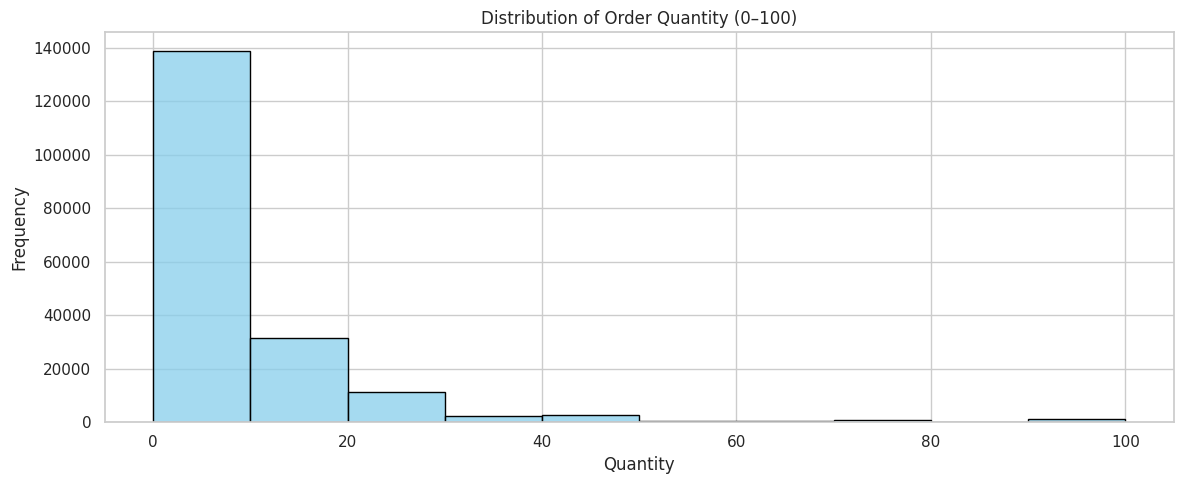

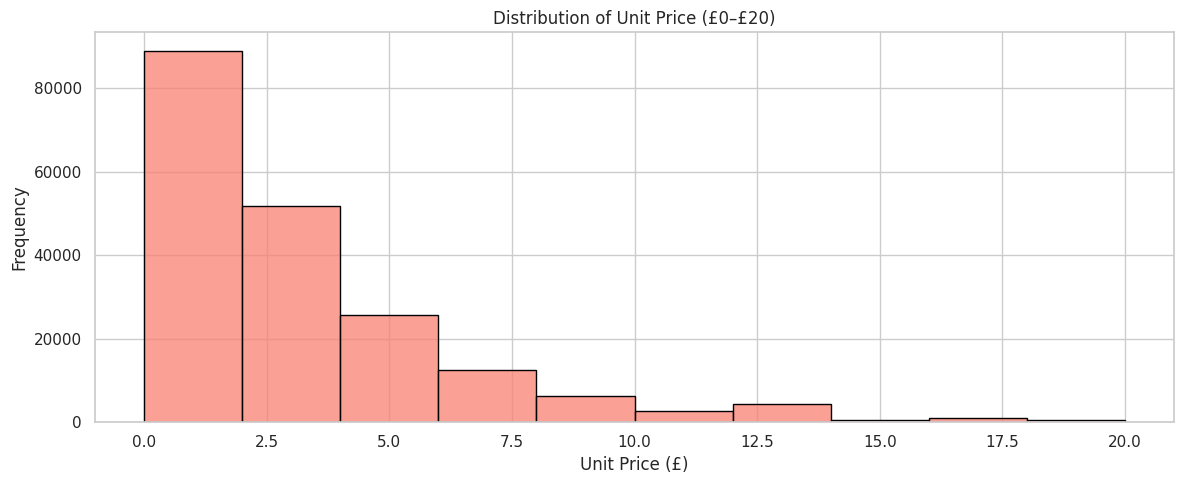

In [ ]:
print("Total Transactions:", len(data))
print("Unique Invoices:", data['Invoice'].nunique())
print("Unique Customers:", data['Customer ID'].nunique())
print("Unique Products (StockCode):", data['StockCode'].nunique())
print("Quantity:\n", data['Quantity'].describe())
print("Price:\n", data['Price'].describe())
print("Top countries (transactions):\n", data['Country'].value_counts().head())


# For Quantity: Focus on majority of orders
plt.figure(figsize=(12, 5))
quantity_bins = np.linspace(0, 100, 11)  # 10 bins: 0-10, 10-20, ..., 90-100
sns.histplot(data[(data['Quantity'] >= 0) & (data['Quantity'] <= 100)]['Quantity'], bins=quantity_bins, color='skyblue', edgecolor='black')
plt.title('Distribution of Order Quantity (0–100)')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('quantity_distribution_proper.png')
plt.show()

# For Price: Focus on £0–£20
plt.figure(figsize=(12, 5))
price_bins = np.linspace(0, 20, 11)
sns.histplot(data[(data['Price'] >= 0) & (data['Price'] <= 20)]['Price'], bins=price_bins, color='salmon', edgecolor='black')
plt.title('Distribution of Unit Price (£0–£20)')
plt.xlabel('Unit Price (£)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('unitprice_distribution_proper.png')
plt.show()




6. Time Series Line Plot with Rolling Average

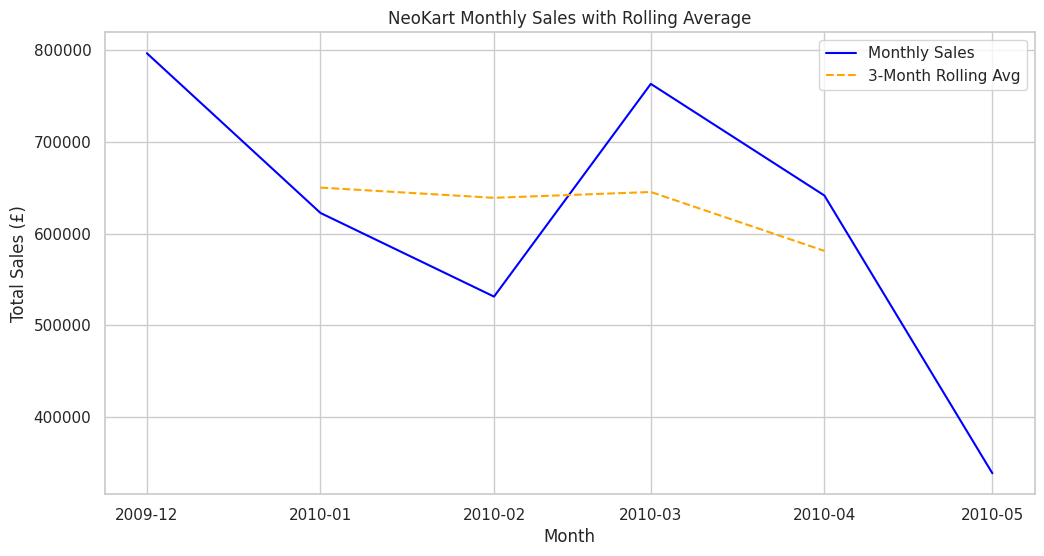

In [ ]:
# Calculate Revenue per transaction
data['Revenue'] = data['Quantity'] * data['Price']

# Convert InvoiceDate to monthly period
data['InvoiceMonth'] = data['InvoiceDate'].dt.to_period('M')

# Group by InvoiceMonth and sum Revenue
monthly_sales = data.groupby('InvoiceMonth')['Revenue'].sum().reset_index()

# Convert InvoiceMonth back to timestamp for plotting
monthly_sales['InvoiceMonth'] = monthly_sales['InvoiceMonth'].dt.to_timestamp()

# Calculate rolling average (3-month window)
monthly_sales['RollingAvg'] = monthly_sales['Revenue'].rolling(window=3, center=True).mean()

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_sales['InvoiceMonth'], monthly_sales['Revenue'], label='Monthly Sales', color='blue')
plt.plot(monthly_sales['InvoiceMonth'], monthly_sales['RollingAvg'], label='3-Month Rolling Avg', color='orange', linestyle='--')
plt.title('NeoKart Monthly Sales with Rolling Average')
plt.xlabel('Month')
plt.ylabel('Total Sales (£)')
plt.legend()
plt.grid(True)
plt.show()


7. Customer Segmentation – RFM Analysis

             Recency  Frequency  Monetary R_Quartile  F_Quartile M_Quartile  \
Customer ID                                                                   
12346.0           77         11    127.05          2           3          1   
12349.0           19          2   1044.37          3           1          4   
12358.0          161          1   1429.83          1           1          4   
12359.0           36          6   1428.23          3           3          4   
12360.0           55          2    158.00          2           1          1   

             RFM_Score  
Customer ID             
12346.0              6  
12349.0              8  
12358.0              6  
12359.0             10  
12360.0              4  


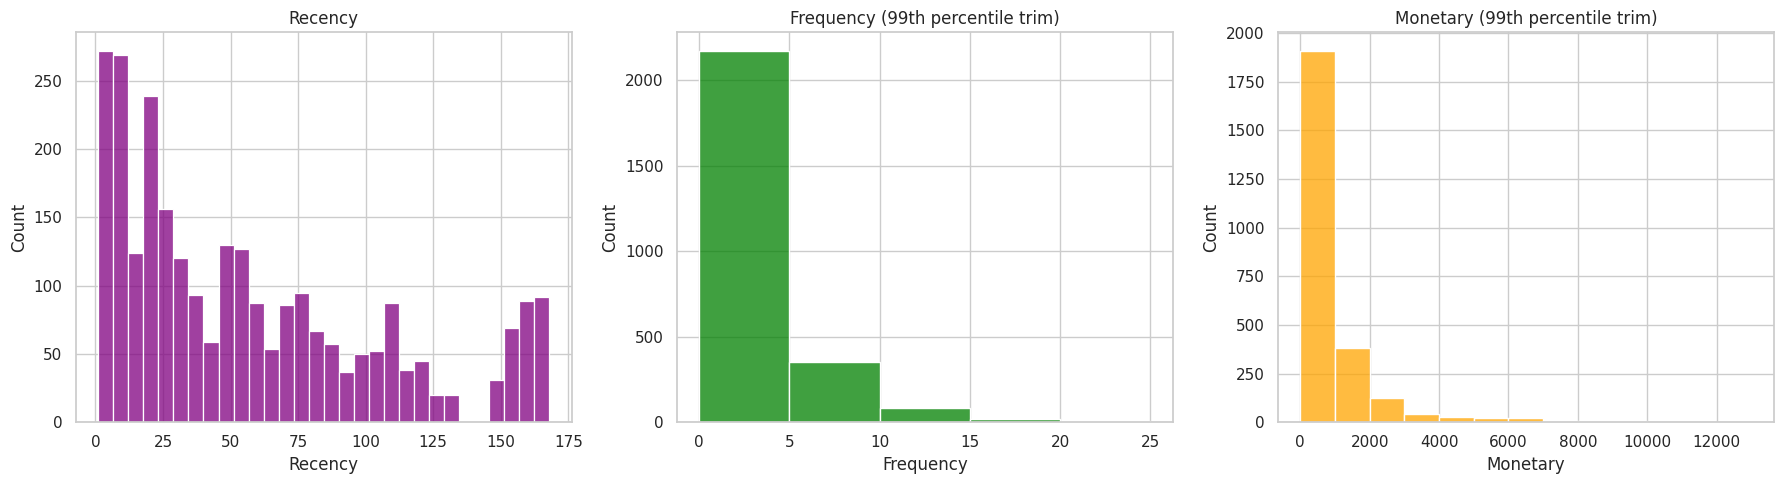

In [ ]:
# RFM Segmentation

# Prepare customer dataset
cust = data.dropna(subset=['Customer ID']).copy()
cust['TotalPrice'] = cust['Quantity'] * cust['Price']
snapshot = cust['InvoiceDate'].max() + pd.Timedelta(days=1)

# Calculate Recency, Frequency, Monetary per Customer ID
rfm = cust.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot - x.max()).days,  # Recency
    'Invoice': 'nunique',                                # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).rename(columns={'InvoiceDate': 'Recency', 'Invoice': 'Frequency', 'TotalPrice': 'Monetary'})

# Recency quartiles
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4,3,2,1])

# Frequency quartiles
freq_qcut, freq_bins = pd.qcut(rfm['Frequency'], 4, duplicates='drop', retbins=True)
rfm['F_Quartile'] = freq_qcut.astype('category').cat.codes + 1

# Monetary quartiles
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1,2,3,4])

# Calculate combined RFM score as sum of quartiles
rfm['RFM_Score'] = rfm[['R_Quartile','F_Quartile','M_Quartile']].astype(int).sum(axis=1)

print(rfm.head())

# RFM Distribution Plots (trim extreme outliers for Frequency and Monetary)


freq_max = np.percentile(rfm['Frequency'], 99)
mon_max = np.percentile(rfm['Monetary'], 99)

fig, axs = plt.subplots(1, 3, figsize=(18,5))
sns.histplot(rfm['Recency'], bins=30, color='purple', ax=axs[0])
axs[0].set_title('Recency')
sns.histplot(rfm[rfm['Frequency'] <= freq_max]['Frequency'], bins=range(0, int(freq_max)+5, 5), color='green', ax=axs[1])
axs[1].set_title('Frequency (99th percentile trim)')
sns.histplot(rfm[rfm['Monetary'] <= mon_max]['Monetary'], bins=range(0, int(mon_max)+1000, 1000), color='orange', ax=axs[2])
axs[2].set_title('Monetary (99th percentile trim)')
plt.tight_layout()
plt.show()


8. Violin Plots for RFM Metric Distributions

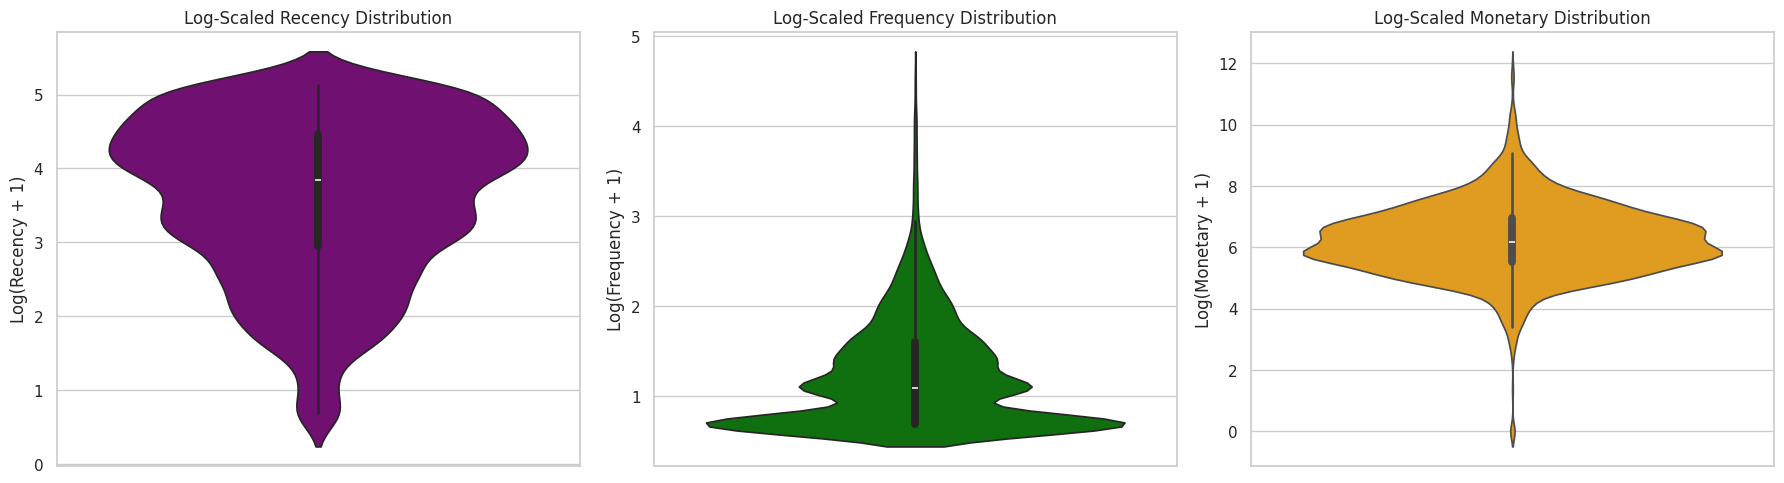

In [ ]:

rfm_log = rfm.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_log[col] = rfm_log[col].mask(rfm_log[col] < 0, np.nan)

rfm_log['Recency_log']   = np.log1p(rfm_log['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_log']  = np.log1p(rfm_log['Monetary'])

fig, axs = plt.subplots(1, 3, figsize=(18,5))

sns.violinplot(y=rfm_log['Recency_log'],   ax=axs[0], color='purple')
axs[0].set_title('Log-Scaled Recency Distribution')
axs[0].set_ylabel('Log(Recency + 1)')

sns.violinplot(y=rfm_log['Frequency_log'], ax=axs[1], color='green')
axs[1].set_title('Log-Scaled Frequency Distribution')
axs[1].set_ylabel('Log(Frequency + 1)')

sns.violinplot(y=rfm_log['Monetary_log'],  ax=axs[2], color='orange')
axs[2].set_title('Log-Scaled Monetary Distribution')
axs[2].set_ylabel('Log(Monetary + 1)')

plt.tight_layout()
plt.show()


9. Treemap of Revenue by SKU

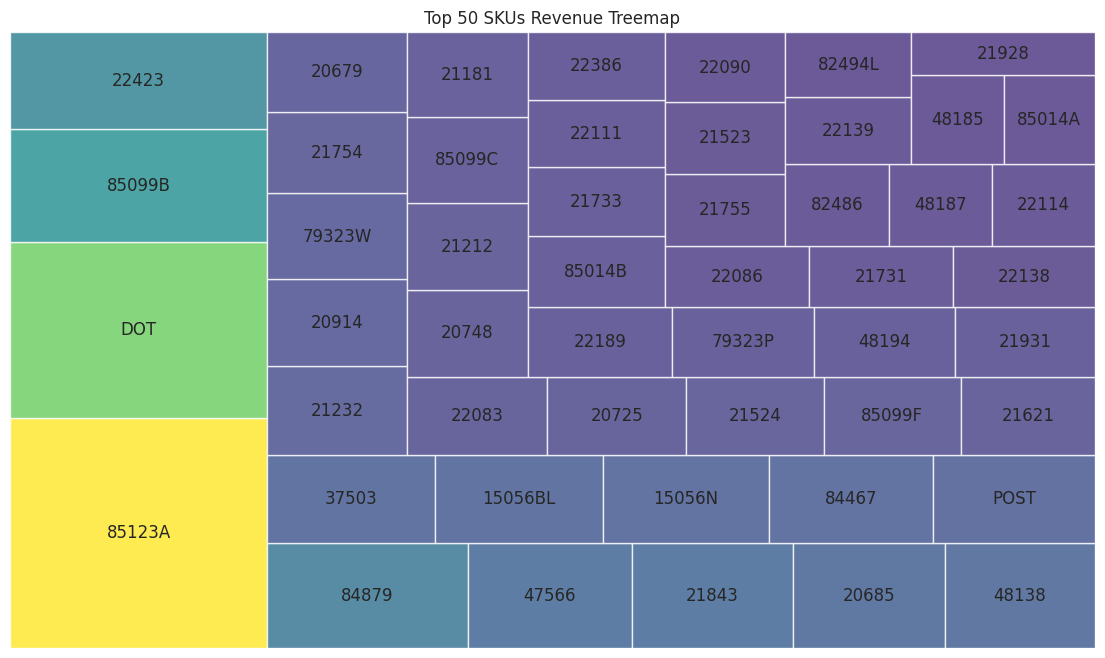

In [ ]:
# 1. Calculate Revenue per row (if not already present)
data['Revenue'] = data['Quantity'] * data['Price']

# 2. Aggregate revenue per SKU using groupby and sum
sku_revenue = data.groupby('StockCode')['Revenue'].sum().reset_index()

# 3. Select top 50 SKUs by revenue
top_skus = sku_revenue.sort_values(by='Revenue', ascending=False).head(50)

# 4. Create Treemap for Top 50 SKUs
!pip install squarify

import squarify


plt.figure(figsize=(14,8))
colors = plt.cm.viridis(top_skus['Revenue'] / top_skus['Revenue'].max())
squarify.plot(
    sizes=top_skus['Revenue'],
    label=top_skus['StockCode'].astype(str),
    color=colors,
    alpha=0.8
)
plt.title('Top 50 SKUs Revenue Treemap')
plt.axis('off')
plt.show()



 10. Product (SKU) Revenue Pareto Chart

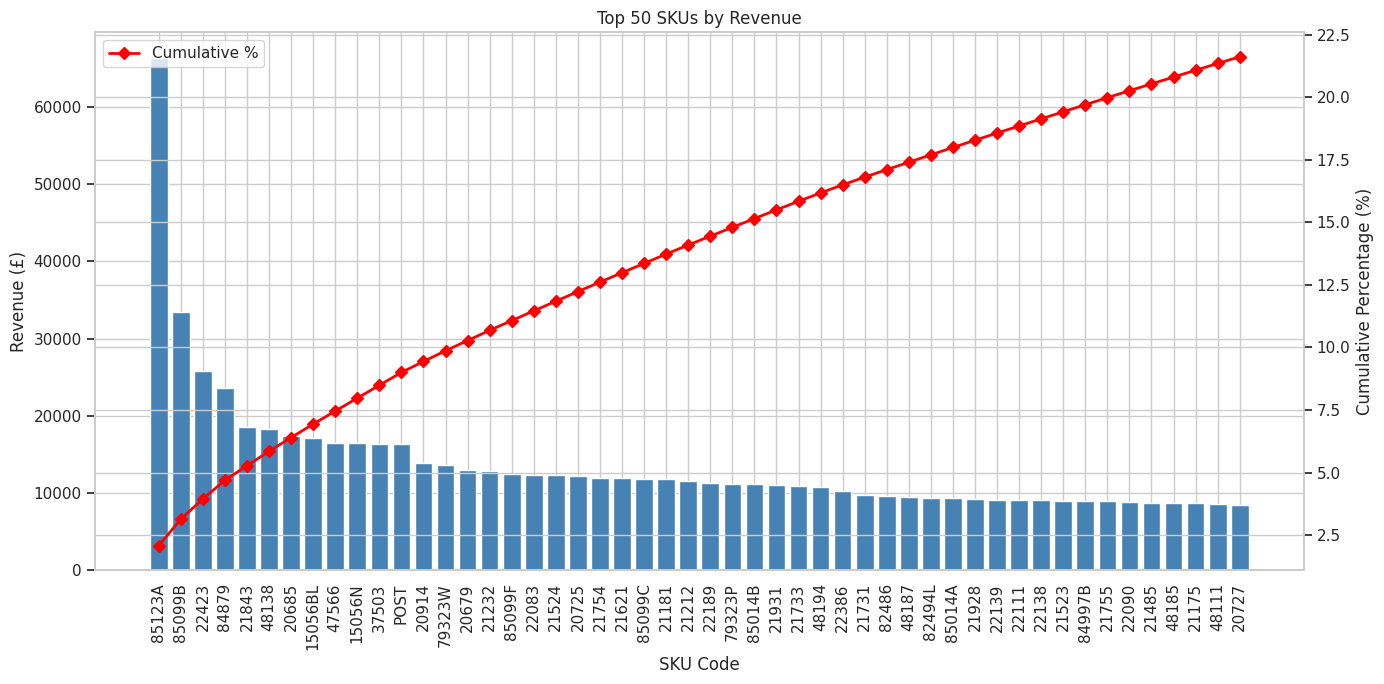

In [ ]:
# SKU Revenue Pareto Chart
sku_revenue = cust.groupby('StockCode')['TotalPrice'].sum().sort_values(ascending=False)
sku_cumperc = 100 * sku_revenue.cumsum() / sku_revenue.sum()

plt.figure(figsize=(14, 7))
plt.bar(sku_revenue.index[:50], sku_revenue.values[:50], color='steelblue')
plt.xticks(rotation=90)
plt.title('Top 50 SKUs by Revenue')
plt.ylabel('Revenue (£)')
plt.xlabel('SKU Code')
plt.twinx()
plt.plot(sku_cumperc[:50], color='red', marker='D', linestyle='-', linewidth=2, label='Cumulative %')
plt.ylabel('Cumulative Percentage (%)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('pareto_sku_revenue.png')
plt.show()


11. Monthly Revenue Trend & ARIMA Forecast

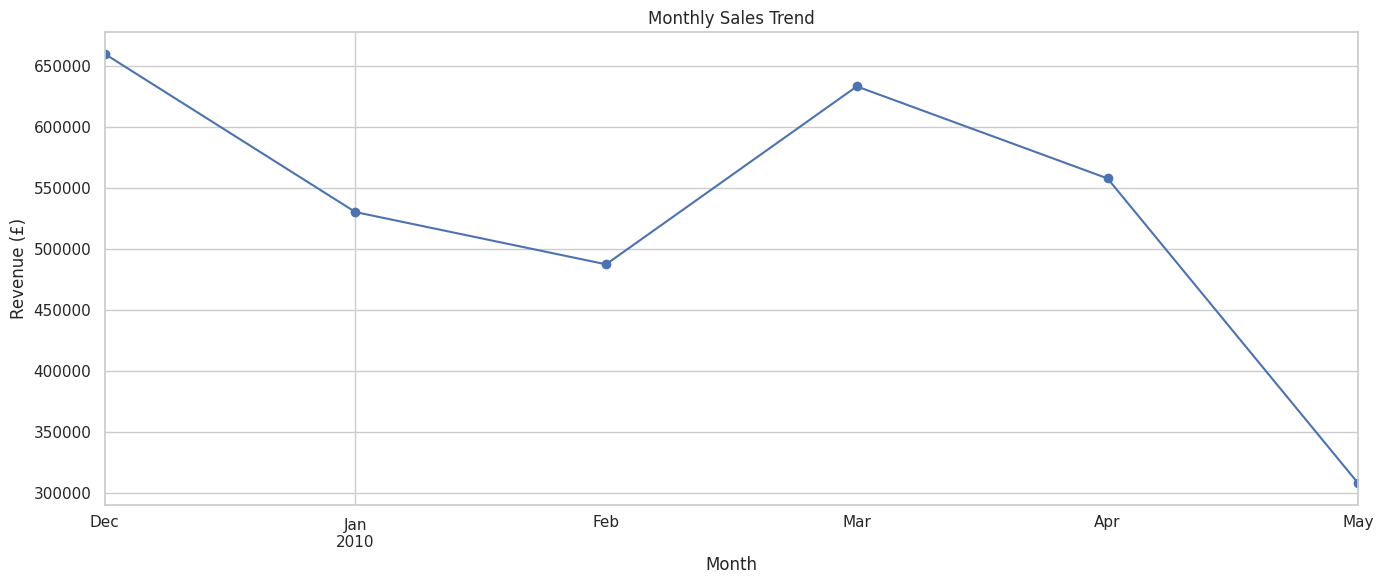

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


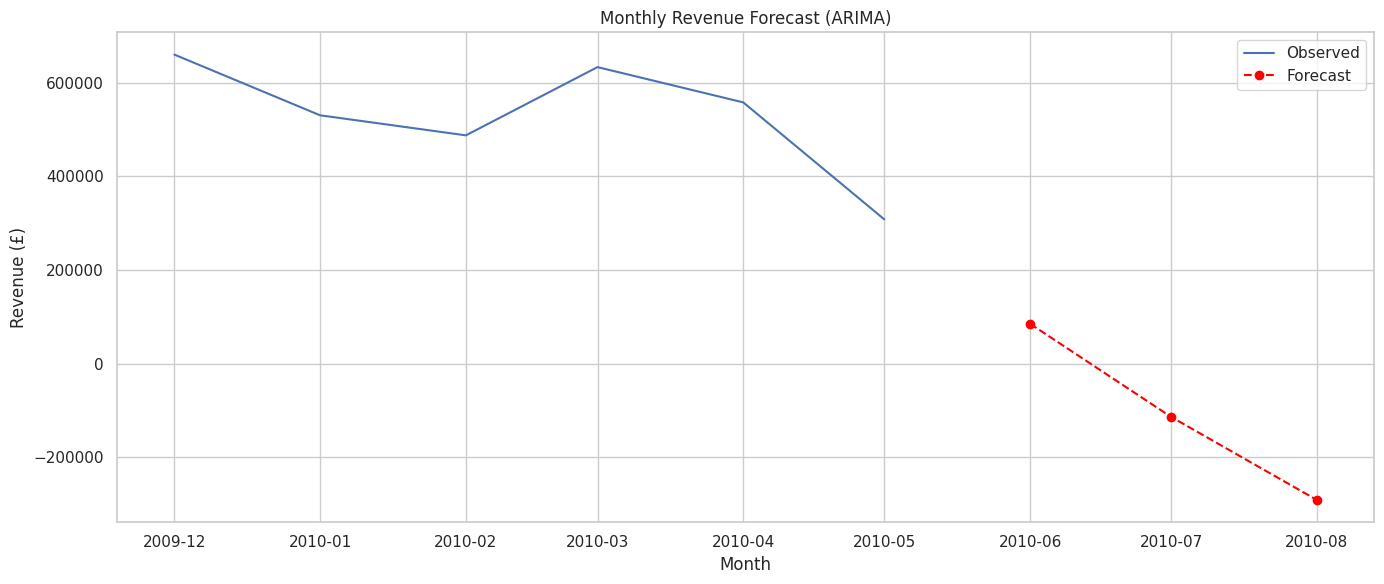

3-Month Forecast Values: [  85069.2023061  -113901.258863   -291429.82497051]


In [ ]:
# Monthly Sales Trend and Forecast

cust['InvoiceMonth'] = cust['InvoiceDate'].dt.to_period('M')
monthly_sales = cust.groupby('InvoiceMonth')['TotalPrice'].sum()

plt.figure(figsize=(14, 6))
monthly_sales.plot(marker='o')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.tight_layout()
plt.savefig('monthly_sales_trend.png')
plt.show()

# ARIMA forecasting
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(monthly_sales.values, order=(1, 1, 1))
fit = model.fit()
forecast = fit.forecast(steps=3)
future_index = pd.period_range(monthly_sales.index[-1] + 1, periods=3, freq='M').to_timestamp()

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales.index.to_timestamp(), monthly_sales.values, label='Observed')
plt.plot(future_index, forecast, marker='o', linestyle='--', color='red', label='Forecast')
plt.legend()
plt.title('Monthly Revenue Forecast (ARIMA)')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')
plt.grid(True)
plt.tight_layout()
plt.savefig('sales_forecast.png')
plt.show()

print("3-Month Forecast Values:", forecast)


13. Top 5 Countries by Revenue

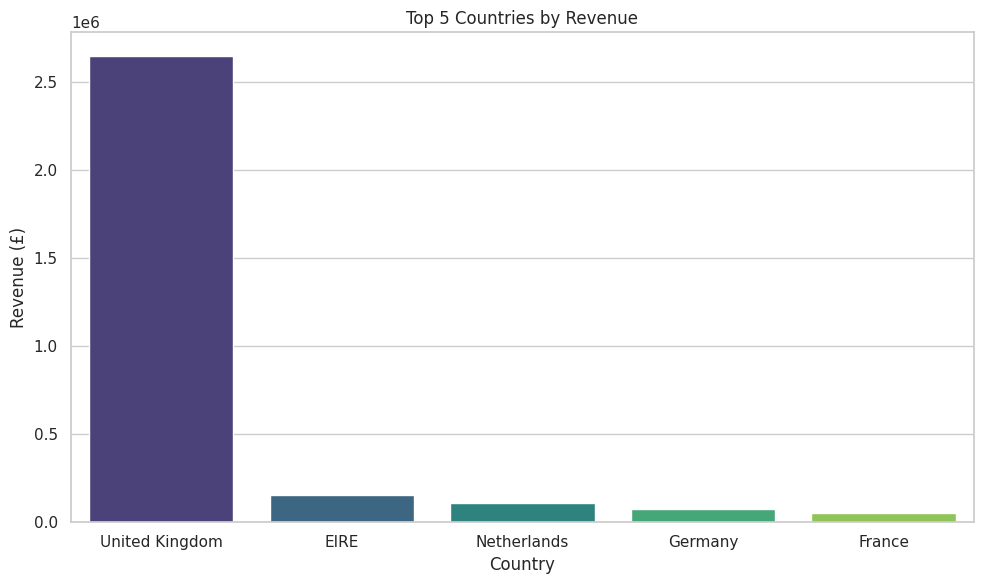

In [ ]:
top_countries = cust.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).head(5).reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=top_countries, x='Country', y='TotalPrice', hue='Country', palette='viridis', legend=False)
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Country')
plt.ylabel('Revenue (£)')
plt.tight_layout()
plt.savefig('top_countries_revenue.png')
plt.show()


14. Choropleth Map of Revenue by Country

In [ ]:
import plotly.express as px

# Aggregate revenue by country
data['Revenue'] = data['Quantity'] * data['Price']
country_revenue = data.groupby('Country')['Revenue'].sum().reset_index()


# Filter to meaningful countries
country_revenue = country_revenue[country_revenue['Revenue'] > 0]

# Plot choropleth map
fig = px.choropleth(country_revenue,
                    locations="Country",
                    locationmode='country names',
                    color="Revenue",
                    color_continuous_scale="Blues",
                    title='NeoKart Revenue by Country',
                    labels={'Revenue':'Total Revenue (£)'},
                    hover_data=['Revenue'])
fig.show()

15. Returns Percentage by Country

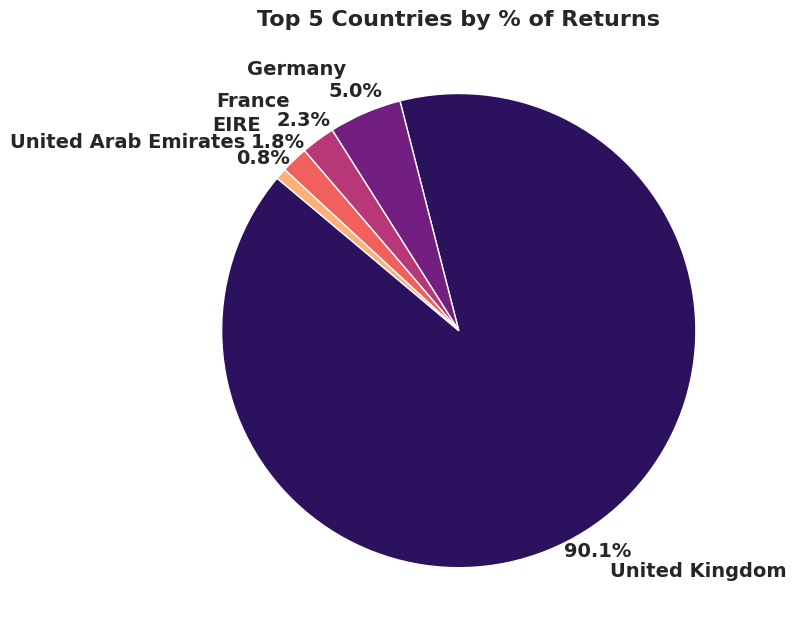

Top 5 Countries by Returns (%):
 Country
United Kingdom          87.222222
Germany                  4.814815
France                   2.245370
EIRE                     1.782407
United Arab Emirates     0.740741
Name: proportion, dtype: float64


In [ ]:
returns = data[data['IsReturn']]
returns_pct = 100 * returns['Country'].value_counts(normalize=True).head(5)

plt.figure(figsize=(8,8))
plt.pie(
    returns_pct.values,
    labels=returns_pct.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('magma', len(returns_pct)),
    pctdistance=1.1,
    labeldistance=1.2,
    textprops={'fontsize': 14, 'weight': 'bold'}
)
plt.title('Top 5 Countries by % of Returns', fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

print("Top 5 Countries by Returns (%):\n", returns_pct)

